# Exercise 3 - Quantum error correction
This notebook contains my solution to exercise 3 of IBM's Quantum Challenge 2021. This solution is very simple and doesn't use any compicated insight, therefore it has a relatively large cost. My name is Emilio Peláez and my GitHub profile is [@epelaaez](https://github.com/epelaaez) if you want to check it out!

### Imports
The next cell imports everything needed for this notebook.

In [6]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, transpile
import qiskit.tools.jupyter
from qiskit.test.mock import FakeTokyo

### Solution
First we define the two quantum registers and one classical registers as done in the problem notebook.

In [3]:
code = QuantumRegister(5,'code')
syn = QuantumRegister(4,'syn')
out = ClassicalRegister(4,'output')

Now, we need to work on the syndrome circuit to make sure all CNOT gates are between connected qubits. First, let's take a look at FakeTokyo's architecture.

In [7]:
backend = FakeTokyo()
backend

<FakeTokyo('fake_tokyo') from None()>

Now let's take a look at which qubits need to be connected for our syndrome circuit. The circuit that the problem notebook gives us by default is the following.

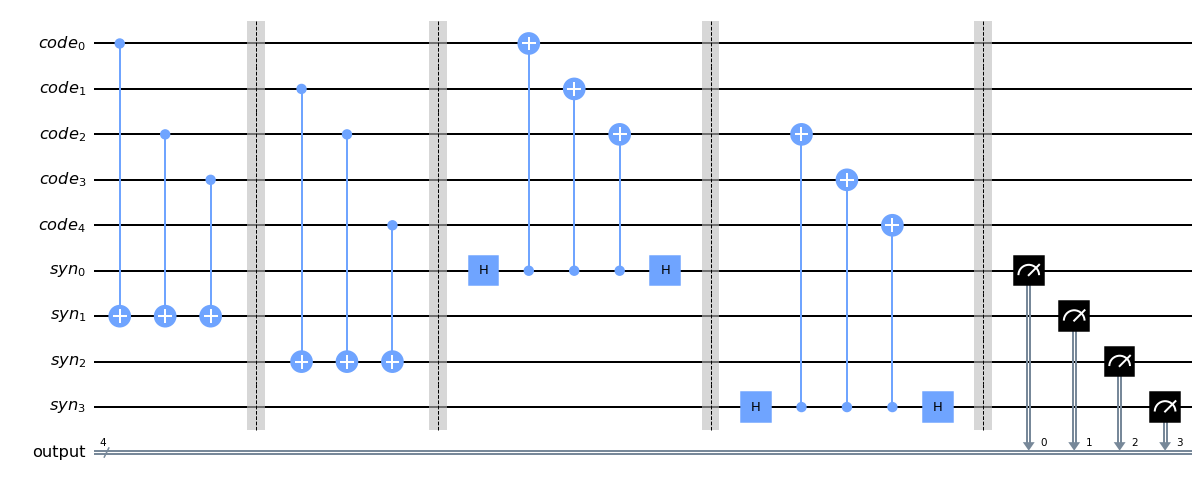

In [9]:
qc_syn = QuantumCircuit(code,syn,out)


# Left ZZZ
qc_syn.cx(code[0],syn[1])
qc_syn.cx(code[2],syn[1])
qc_syn.cx(code[3],syn[1])
qc_syn.barrier()

# Right ZZZ
qc_syn.cx(code[1],syn[2])
qc_syn.cx(code[2],syn[2])
qc_syn.cx(code[4],syn[2])
qc_syn.barrier()

# Top XXX
qc_syn.h(syn[0])
qc_syn.cx(syn[0],code[0])
qc_syn.cx(syn[0],code[1])
qc_syn.cx(syn[0],code[2])
qc_syn.h(syn[0])
qc_syn.barrier()

# Bottom XXX
qc_syn.h(syn[3])
qc_syn.cx(syn[3],code[2])
qc_syn.cx(syn[3],code[3])
qc_syn.cx(syn[3],code[4])
qc_syn.h(syn[3])
qc_syn.barrier()


# Measure the auxilliary qubits
qc_syn.measure(syn,out)
qc_syn.draw('mpl')

Anaylizing this, we find that the following connectivity chart: 

```
c0....s0....c1
:      :     :        
:      :     :
s1....c2....s2
:      :     :
:      :     :
c3....s3....c4
```

We also have that the mapping of the qubits from our circuit to the hardware is giving by the following array:

In [10]:
initial_layout = [0,2,6,10,12,1,5,7,11]

This means that `code[0]` will map to qubit 0 on the device, `code[1]` to qubit 2, and so on. After looking at this and checking with qubits have a direct connection on the device, we see that the only CNOT that will not work on hardware is the first one on the Right ZZZ block, i.e. between `code[1]` and `syn[2]`.

The easiest thing to do here is to build a series of gates that perform the same operation than a CNOT without the two gates being actually connected to each other. And doing this is easy using an ancilla qubit. At this point in the circuit, we have two options for ancilla qubits, `syn[0]` and `syn[3]`; we cannot use `syn[1]` since it has already been used by the first block and it's best to not change its state. I chose to use `syn[0]`.

The code is rather easy. First, we apply a CNOT gate with `code[1]` as control and `syn[0]`. Since `syn[0]` is still in the 0 state, it will take on the state of `code[1]` after the CNOT. Then, we apply a CNOT gate with `syn[0]` as control and `syn[2]` as target, this will have the same effect as a CNOT between `code[1]` and `syn[2]` directly. Finally, we apply the first CNOT again to reverse `syn[0]` to the 0 state. The code looks as follows.

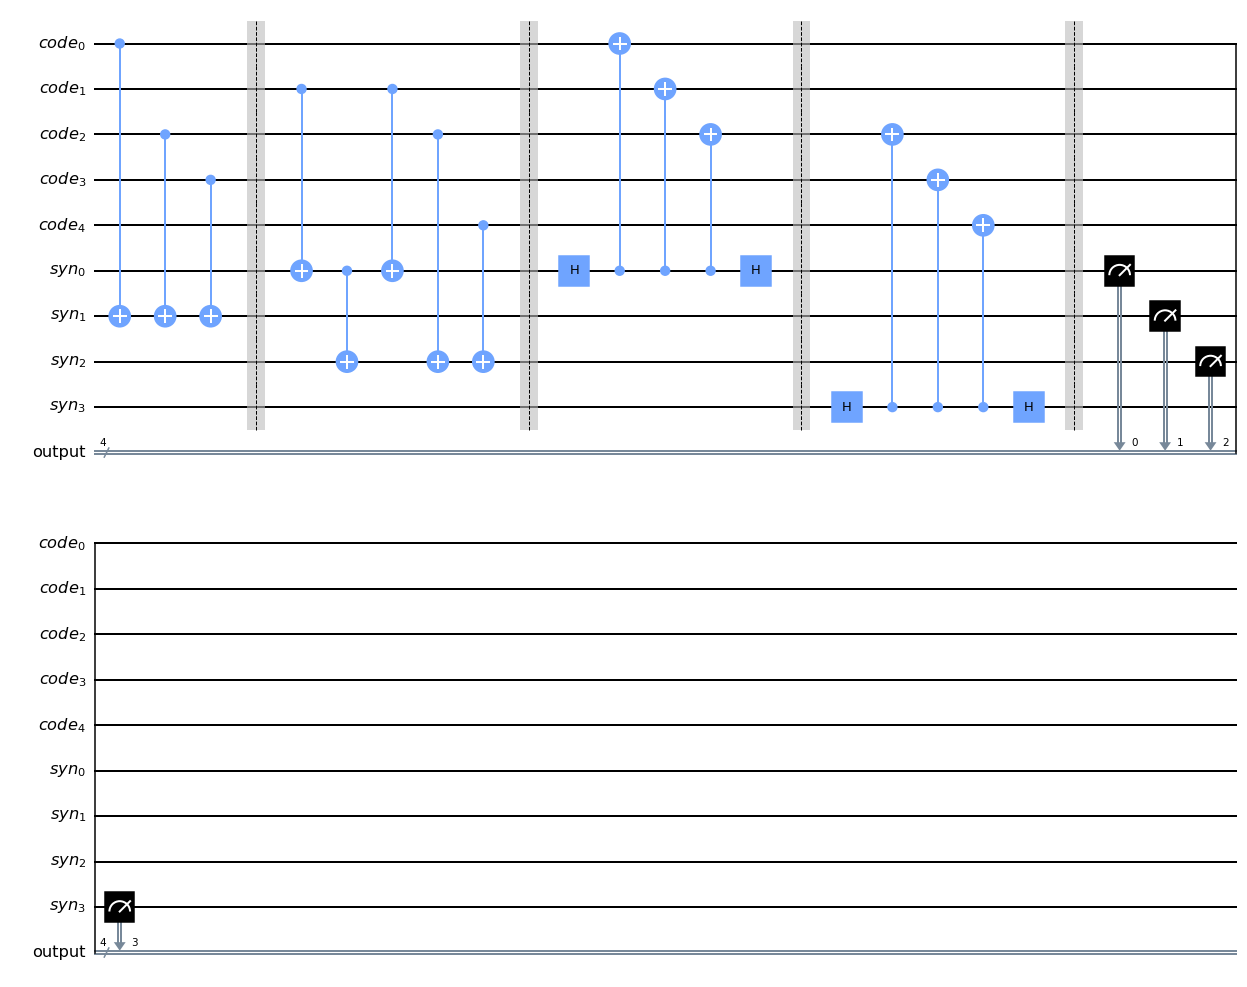

In [11]:
qc_syn = QuantumCircuit(code,syn,out)


# Left ZZZ
qc_syn.cx(code[0],syn[1])
qc_syn.cx(code[2],syn[1])
qc_syn.cx(code[3],syn[1])
qc_syn.barrier()

# Right ZZZ
qc_syn.cx(code[1],syn[0])
qc_syn.cx(syn[0], syn[2])
qc_syn.cx(code[1],syn[0])
qc_syn.cx(code[2],syn[2])
qc_syn.cx(code[4],syn[2])
qc_syn.barrier()

# Top XXX
qc_syn.h(syn[0])
qc_syn.cx(syn[0],code[0])
qc_syn.cx(syn[0],code[1])
qc_syn.cx(syn[0],code[2])
qc_syn.h(syn[0])
qc_syn.barrier()

# Bottom XXX
qc_syn.h(syn[3])
qc_syn.cx(syn[3],code[2])
qc_syn.cx(syn[3],code[3])
qc_syn.cx(syn[3],code[4])
qc_syn.h(syn[3])
qc_syn.barrier()


# Measure the auxilliary qubits
qc_syn.measure(syn,out)
qc_syn.draw('mpl')

Above you can see that the modifications to the orignal circuit were minimal. Then, the init circuit is left as given since it already matches with FakeyTokyo's architecture.

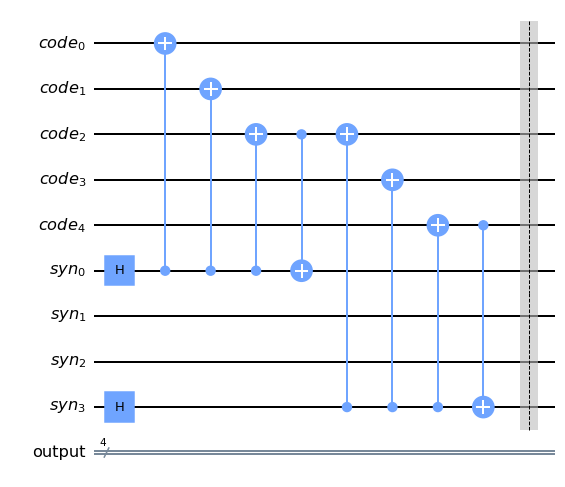

In [12]:
qc_init = QuantumCircuit(code,syn,out)

qc_init.h(syn[0])
qc_init.cx(syn[0],code[0])
qc_init.cx(syn[0],code[1])
qc_init.cx(syn[0],code[2])
qc_init.cx(code[2],syn[0])

qc_init.h(syn[3])
qc_init.cx(syn[3],code[2])
qc_init.cx(syn[3],code[3])
qc_init.cx(syn[3],code[4])
qc_init.cx(code[4],syn[3])

qc_init.barrier()
qc_init.draw('mpl')

And we compose both circuits.

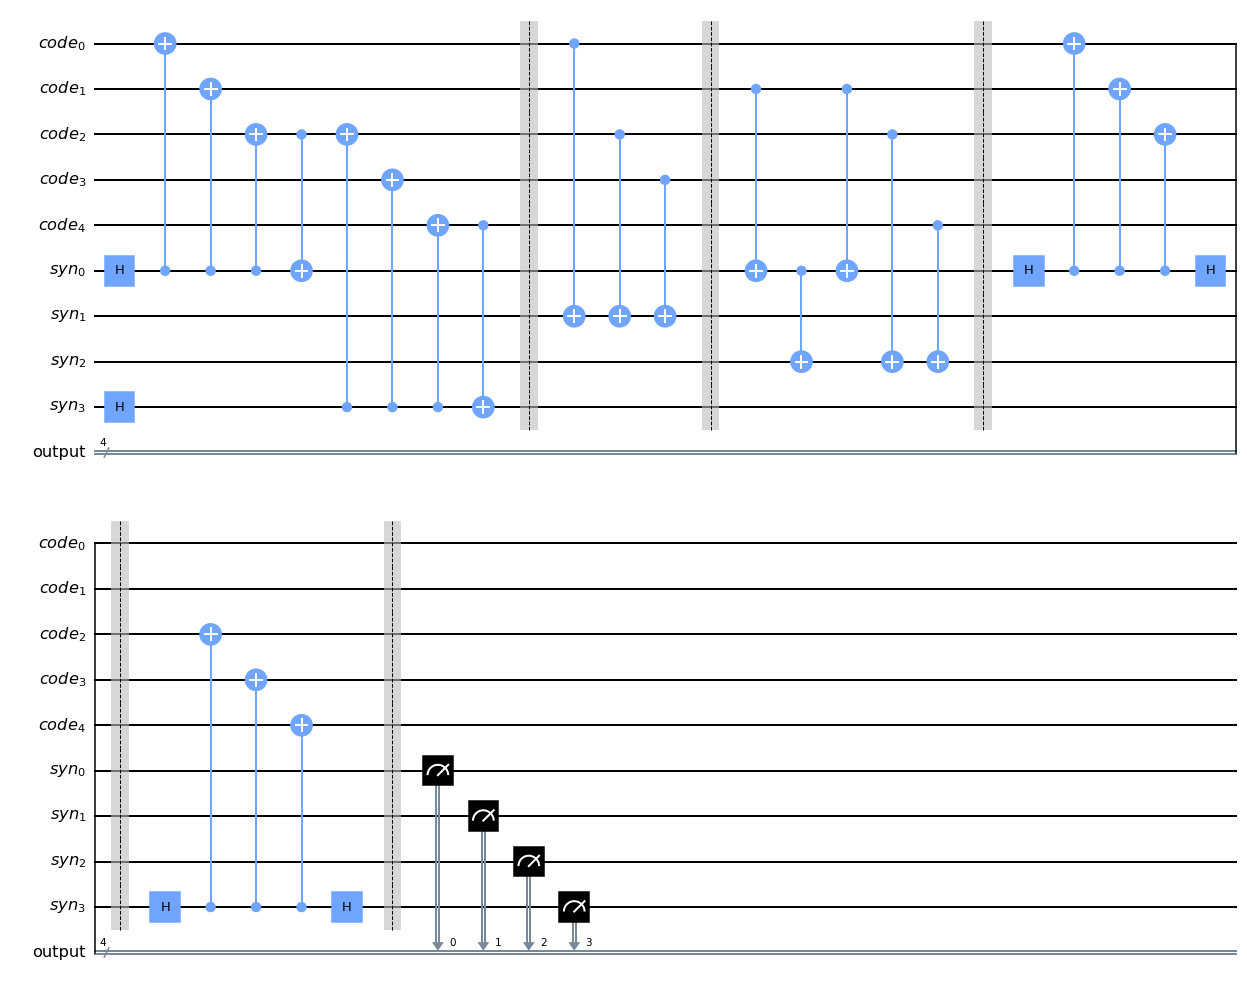

In [13]:
qc = qc_init.compose(qc_syn)
display(qc.draw('mpl'))

To check that our circuit runs correctly, we define the error qubits and insert some artifical errors to make sure we can detect them.

In [14]:
error_qubits = [0,4]

def insert(errors,error_qubits,code,syn,out):

    qc_insert = QuantumCircuit(code,syn,out)

    if 'x0' in errors:
        qc_insert.x(error_qubits[0])
    if 'x1' in errors:
        qc_insert.x(error_qubits[1])
    if 'z0' in errors:
        qc_insert.z(error_qubits[0])
    if 'z1' in errors:
        qc_insert.z(error_qubits[1])
        
    return qc_insert

for error in ['x0','x1','z0','z1']:
    
    qc = qc_init.compose(insert([error],error_qubits,code,syn,out)).compose(qc_syn)
    job = Aer.get_backend('qasm_simulator').run(qc)
    
    print('\nFor error '+error+':')
    counts = job.result().get_counts()
    for output in counts:
        print('Output was',output,'for',counts[output],'shots.')


For error x0:
Output was 0010 for 1024 shots.

For error x1:
Output was 0100 for 1024 shots.

For error z0:
Output was 0001 for 1024 shots.

For error z1:
Output was 1000 for 1024 shots.


As you can see, we detect all four types of errors correctly and with a different value each. To wrap things up, we run the grader and see that our answer is correct.

In [15]:
from qc_grader import grade_ex3
grade_ex3(qc_init,qc_syn,error_qubits,initial_layout)

Grading your answer for ex3. Please wait...

Congratulations 🎉! Your answer is correct.
Your cost is 226.
Feel free to submit your answer.

